In [1]:
!pip install pandas-datareader

In [2]:
!pip install yfinance

In [3]:
# Импорт необходимых библиотек:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime
import yfinance as yf

In [4]:
# Загрузка данных по золоту:

start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2023, 4, 23)

gold_data = yf.download('GC=F', start=start_date, end=end_date)
gold_data = gold_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [5]:
# Расчет скользящих средних:

def add_moving_averages(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()
    return data

short_window = 50
long_window = 200
gold_data = add_moving_averages(gold_data, short_window, long_window)

/var/folders/gh/l8kky5ls3f38lr083tb8lpgw0000gn/T/ipykernel_59647/4079195133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
/var/folders/gh/l8kky5ls3f38lr083tb8lpgw0000gn/T/ipykernel_59647/4079195133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Long_MA'] = data['Close'].rolling(window=long_window).mean()


In [6]:
# Реализация стратегии:

def implement_strategy(data, transaction_cost):
    data['Position'] = None
    data['Transaction'] = None
    
    for i in range(long_window, len(data)):
        if data['Short_MA'][i] > data['Long_MA'][i] and data['Short_MA'][i - 1] <= data['Long_MA'][i - 1]:
            data.at[data.index[i], 'Position'] = 1
            data.at[data.index[i], 'Transaction'] = transaction_cost
        elif data['Short_MA'][i] < data['Long_MA'][i] and data['Short_MA'][i - 1] >= data['Long_MA'][i - 1]:
            data.at[data.index[i], 'Position'] = -1
            data.at[data.index[i], 'Transaction'] = transaction_cost
        else:
            data.at[data.index[i], 'Position'] = 0
            data.at[data.index[i], 'Transaction'] = 0
    
    data['Strategy_Return'] = data['Close'].pct_change() * data['Position'].shift(1) - data['Transaction']
    data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()
    
    return data

transaction_cost = 0.001
gold_data = implement_strategy(gold_data, transaction_cost)


/var/folders/gh/l8kky5ls3f38lr083tb8lpgw0000gn/T/ipykernel_59647/395604756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = None
/var/folders/gh/l8kky5ls3f38lr083tb8lpgw0000gn/T/ipykernel_59647/395604756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction'] = None


In [7]:
# Разделение данных на обучающий и тестовый периоды:

train_data = gold_data[gold_data.index < '2022-01-01']
test_data = gold_data[gold_data.index >= '2022-01-01']


In [8]:
# Расчет статистик:

def calculate_stats(data, trading_days_per_year=252):
    returns = data['Strategy_Return'].dropna()
    sharpe_ratio = np.sqrt(trading_days_per_year) * returns.mean() / returns.std()
    drawdowns = (1 - data['Cumulative_Return'].div(data['Cumulative_Return'].cummax())) * 100
    max_drawdown = drawdowns.max()
    
    # Находим максимальный срок просадки
    drawdown_timedelta = drawdowns.index.to_series().diff().fillna(pd.Timedelta(days=0))
    max_drawdown_period = drawdown_timedelta[drawdowns == max_drawdown].max()
    
    calmar_ratio = returns.mean() / max_drawdown
    acc_return_max_drawdown = data['Cumulative_Return'][-1] / max_drawdown
    value_at_risk = returns.quantile(0.05)
    expected_shortfall = returns[returns <= value_at_risk].mean()

    stats = {
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Accumulated Return / Max Drawdown': acc_return_max_drawdown,
        'Value at Risk': value_at_risk,
        'Expected Shortfall': expected_shortfall,
        'Max Drawdown': max_drawdown,
        'Max Drawdown Period': max_drawdown_period
    }

    return stats

In [9]:
# Расчет статистик для обучающего и тестового периодов:

train_stats = calculate_stats(train_data)
test_stats = calculate_stats(test_data)

In [10]:
# Вывод статистик и проверка условий:

if test_stats['Sharpe Ratio'] > train_stats['Sharpe Ratio'] and test_stats['Max Drawdown'] < 30:
    print("Условия соблюдены")
    print("\nСтатистика обучающего периода:")
    for key, value in train_stats.items():
        print(f"{key}: {value}")
    
    print("\nСтатистика тестового периода:")
    for key, value in test_stats.items():
        print(f"{key}: {value}")
else:
    print("Условия не соблюдены")


Условия соблюдены

Статистика обучающего периода:
Sharpe Ratio: -0.09914782828495428
Calmar Ratio: -2.034573427535571e-06
Accumulated Return / Max Drawdown: 0.41845316163197993
Value at Risk: 0.0
Expected Shortfall: -2.921406779284067e-05
Max Drawdown: 2.373777736796312
Max Drawdown Period: 4 days 00:00:00

Статистика тестового периода:
Sharpe Ratio: 0.013964117348720002
Calmar Ratio: 1.039797330226828e-06
Accumulated Return / Max Drawdown: 1.2992532214692205
Value at Risk: 0.0
Expected Shortfall: -4.438953861131992e-05
Max Drawdown: 0.7646255082564224
Max Drawdown Period: 1 days 00:00:00


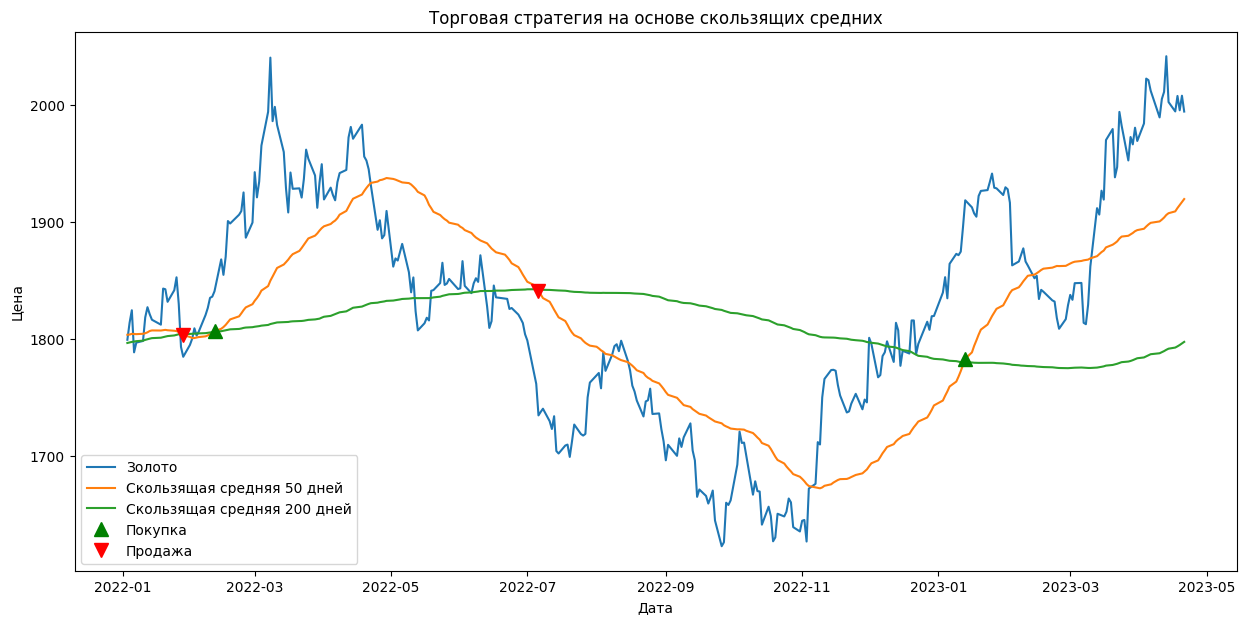

In [11]:
# Графическая визуализация стратегии:

def plot_strategy(data):
    plt.figure(figsize=(15, 7))
    plt.plot(data['Close'], label='Золото')
    plt.plot(data['Short_MA'], label=f'Скользящая средняя {short_window} дней')
    plt.plot(data['Long_MA'], label=f'Скользящая средняя {long_window} дней')
    plt.plot(data.loc[data['Position'] == 1].index, data['Short_MA'][data['Position'] == 1], '^', markersize=10, color='g', label='Покупка')
    plt.plot(data.loc[data['Position'] == -1].index, data['Short_MA'][data['Position'] == -1], 'v', markersize=10, color='r', label='Продажа')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.title('Торговая стратегия на основе скользящих средних')
    plt.legend()
    plt.show()

plot_strategy(test_data)



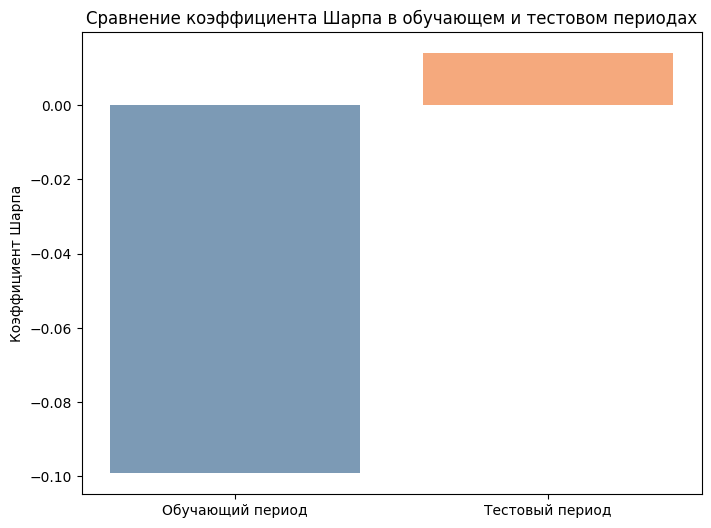

In [12]:
# Сравнение коэффициента Шарпа в обучающем и тестовом периодах:

def plot_sharpe_difference(train_stats, test_stats):
    sharpe_train = train_stats['Sharpe Ratio']
    sharpe_test = test_stats['Sharpe Ratio']
    
    plt.figure(figsize=(8, 6))
    plt.bar(['Обучающий период', 'Тестовый период'], [sharpe_train, sharpe_test], color=['#7C9AB5', '#F5A97D'])
    plt.ylabel('Коэффициент Шарпа')
    plt.title('Сравнение коэффициента Шарпа в обучающем и тестовом периодах')
    plt.show()

plot_sharpe_difference(train_stats, test_stats)
